In [25]:
import numpy as np
import pandas as pd
import itertools
import geopandas as gpd
import rasterio
import fiona
import sklearn.model_selection as model_selection
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset, TensorDataset
import torcheval.metrics as metrics

import matplotlib.pyplot as plt

In [26]:
import bird_data as data

In [27]:
junco_data = data.junco_data.drop(columns = ['year', 'day_of_year', 'hours_of_day'])
junco_data['observation_date'] = pd.to_datetime(junco_data['observation_date'])
junco_data.sort_values(by = 'observation_date', inplace = True)

In [28]:
def build_features(data, time_lag: int = 1, seq_len: int = 14):
    n = data.size(0)
    x = []
    y = []
    for i in range(seq_len, n - time_lag):
        x.append(data[i - seq_len: i])
        y.append(data[i + time_lag])
    x, y = np.array(x), np.array(y)
    x = torch.tensor(x, dtype = torch.float32)
    y = torch.tensor(y, dtype = torch.float32)
    return x, y

def build_loaders(data, train_percent: int = 0.8, time_lag: int = 1,
                  seq_length: int = 14, batch_size: int = 25):
    data = torch.from_numpy(data).to(torch.float32)
    data = np.reshape(data, (-1, 1))

    split = int(np.floor(len(data) * train_percent))

    data_train = data[:split]
    data_test = data[split:]

    x_train, y_train = build_features(data_train, time_lag,
                                      seq_length)
    x_test, y_test = build_features(data_test, time_lag, 
                                    seq_length)

    train_set = TensorDataset(x_train, y_train)
    test_set = TensorDataset(x_test, y_test)

    train_loader = DataLoader(train_set, 
                             batch_size = batch_size,
                             shuffle = False)

    test_loader = DataLoader(test_set, 
                             batch_size = batch_size,
                             shuffle = False)
    return train_loader, test_loader

In [32]:
trainloader, testloader = build_loaders(junco_data['observation_count'].dropna().values, 0.8)

In [30]:
def stock_lstm(train_loader,
               test_loader,
               num_inputs: int = 1,
               num_outputs: int = 1,
               dim_hidden: int = 100,
               num_epochs: int = 10, 
               layers: int = 4,
               dropout: bool = False,
               dropout_rate: float = 0.2, 
               loss_fn = nn.MSELoss,
               optimizer = torch.optim.SGD,
               learning_rate: float = 0.01):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    torch.manual_seed(6260)
    torch.cuda.manual_seed_all(6260)

    ## Define Model
    class LSTM_Model(nn.Module):
        def __init__(self, input, hidden_dim, output_dim, num_layers, dropout):
            super(LSTM_Model, self).__init__()
            self.hidden_dim = hidden_dim
            self.layer_dim = num_layers
            self.output_dim = output_dim
            self.lstm = nn.LSTM(input_size = input,
                                hidden_size = hidden_dim,
                                num_layers = num_layers, 
                                dropout = dropout_rate if dropout else 0,
                                batch_first = True)
            self.fc = nn.Linear(hidden_dim, output_dim)

        def adjust_states(self, h_0, c_0, target_batch_size):
            current_batch_size = h_0.size(1)  # current batch size from h_0
            if target_batch_size < current_batch_size:
                ## Slice the hidden states if the batch size is reduced
                h_0 = h_0[:, :target_batch_size, :].contiguous()
                c_0 = c_0[:, :target_batch_size, :].contiguous()
            if target_batch_size > current_batch_size:
                ## Pad the hidden states if the batch size is increased
                h_0 = torch.cat([h_0, torch.zeros(self.layer_dim, target_batch_size - current_batch_size, self.hidden_dim).to(h_0.device)], dim=1)
                c_0 = torch.cat([c_0, torch.zeros(self.layer_dim, target_batch_size - current_batch_size, self.hidden_dim).to(c_0.device)], dim=1)
            else:
                return h_0, c_0
            
            return h_0, c_0

        def forward(self, x, h_0 = None, c_0 = None):
            if h_0 is None or c_0 is None:
                h_0 = torch.zeros(self.layer_dim, 
                                  x.size(0), 
                                 self.hidden_dim).to(x.device)
                c_0 = torch.zeros(self.layer_dim, 
                                  x.size(0), 
                                 self.hidden_dim).to(x.device)
            h_0, c_0 = self.adjust_states(h_0, c_0, x.size(0))
            out, (h_n, c_n) = self.lstm(x, (h_0, c_0))
            out = self.fc(out[:, -1, :])
            return out, h_n, c_n
        
    ## Initializes Model
    model = LSTM_Model(input = num_inputs, hidden_dim = dim_hidden, output_dim = num_outputs,
                 num_layers = layers, dropout = dropout).to(device)
    criterion = loss_fn()
    optim = optimizer(model.parameters(), lr = learning_rate)

    ## Train Model
    print("Starting training...")
    train_loss = []
    validation_loss = []

    for epoch in range(num_epochs):
        h_0, c_0 = None, None
        model.train()
        outputs = []
        running_loss = 0.0
        for train_x, train_y in train_loader:
            optim.zero_grad()
            train_pred, h_0, c_0 = model(
                train_x.to(device),
                h_0 = h_0,
                c_0 = c_0)
            loss = criterion(train_pred, 
                            train_y.to(device))
            loss.backward()
            optim.step()
            h_0 = h_0.detach()
            c_0 = c_0.detach()
            
            outputs.append(train_pred.cpu().detach().numpy().flatten())
            running_loss += loss.item()
        
        train_loss.append(running_loss / len(train_loader.dataset))

        if (epoch + 1) % 50 == 0:
                print(f'Epoch: {epoch + 1} / {num_epochs}; Training Loss: {running_loss:.4f}\n')


        ## Validate Model
        h_0 = h_0
        c_0 = c_0
        predictions = []
        running_val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for test_x, test_y in test_loader:
                test_pred, h_0, c_0 = model(
                    test_x.to(device),
                    h_0 = h_0,
                    c_0 = c_0)

                pred_loss = criterion(test_pred, 
                                test_y.to(device))
                running_val_loss += pred_loss.item()

                predictions.append(test_pred.cpu().detach().numpy().flatten())
                h_0 = h_0.detach()
                c_0 = c_0.detach()

            validation_loss.append(running_val_loss / len(test_loader.dataset))

            if (epoch + 1) % 50 == 0:
                print(f'Epoch: {epoch + 1} / {num_epochs}; Validation Loss: {running_val_loss:.4f}\n')

    predictions = np.concatenate(predictions)
    predictions = np.reshape(predictions, (-1, 1))

    outputs = np.concatenate(outputs)
    outputs = np.reshape(outputs, (-1, 1))

    return train_loss, validation_loss, outputs, predictions

In [39]:
_, _, out, pred = stock_lstm(trainloader, testloader)

Starting training...


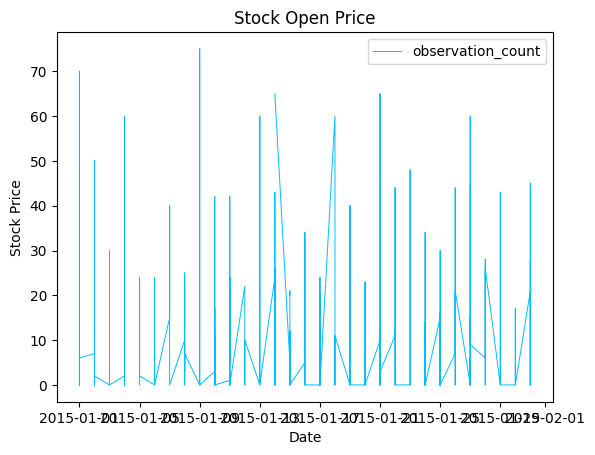

In [37]:
plt.plot('observation_date', 'observation_count', data = junco_data, 
            c = 'deepskyblue',  
            linestyle = '-', linewidth = 0.7)
# plt.xticks(stocks['observation_date'].loc[np.arange(0, 1259, 180)], rotation = 45)
plt.ylabel('Stock Price')
plt.xlabel('Date')
plt.title('Stock Open Price')
plt.legend()
plt.show()

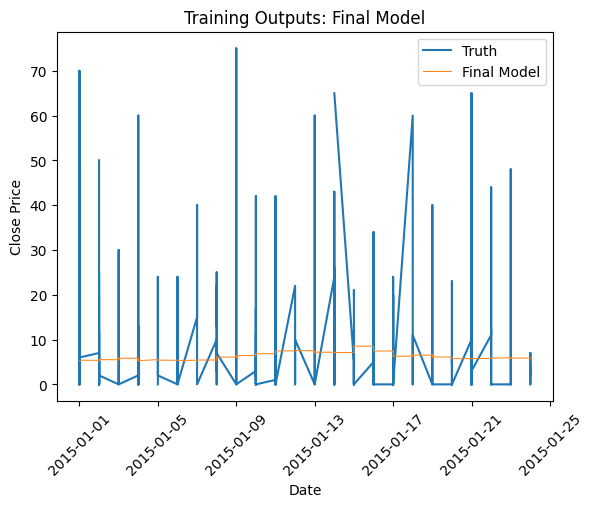

In [42]:
plt.plot(junco_data['observation_date'][:800], junco_data['observation_count'][:800], label = "Truth")
plt.plot(junco_data['observation_date'][42:800], out, label = "Final Model", linewidth = 0.7)
plt.xticks(rotation = 45)
plt.title("Training Outputs: Final Model")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()